## Colocation \* N, precipitation any effects?
Report for course *eScience Tools in Climate Science: Linking Observations with Modelling*.  

Arttu Väisänen  
arttu.vaisanen@fmi.fi  
Finnish Meteorological Institute  
25 november 2022

### Abstract

In this study effect of precipitation to aerosol extinction coefficient between Zepplin station and CALIPSO satellite are studied. This is done using measurements collected in Zepplin station, CALIPSO satellite measurements and ERA5 reanalysis. Effect is being studied using satellite lidar measurements on points were satellite location and air mass backwards trajectories intersect. These measurement are compared to lidar measurements in Zepplin station corresponding to air mass backwards trajectories that contained an intersection point with satellite. From these lidar measurements an absolute difference is calculated and then analysed with total precipitation data from HYSPLIT4 model and ERA5 reanalysis. 

Due to time limits for processing data and limited amount of detected particulates from this processed data the usable amount of data is very small. Because of this it is very difficult to make any reliable estimates of the possible effects of precipitation to the aerosol extinction coefficient. It can be speculated that with larger amount of data trends and clusters might emerge that could be analysed. Also more variables could be included to analysis and some more advanced methods could be used.

### 1 Introduction
This study focuses on question can precipitation explain a change in aerosol extinction coefficient during the transport between Zepplin station and satellite measurements. It is also conducted as part of group that concentrated on effects of precipitation on aerosol populations in polar regions. The topic of this study is important because it has been predicted that precipitation will increase globaly and especially in arctic regions in the future. Due to this better understanding of precipitation on arctic region is vital due to its far reaching effects on climatology, hydrology and various other fields. Potentially it can also open new ways to research precipitation near measurement stations.

In this study lidar measurements from Zepplin station and CALIPSO satellite were used to study the effect of precipitation on aerosol extinction coefficient. This is conducted by colocating intersection points of CALIPSO satellite and air mass backward trajectories from Zepplin station. From these colocation points lidar measurements from CALIPSO satellite of aerosol extionction coefficient are collected. The aerosol extinction coefficients measurements in Zepplin station corresponding to colocated intersection points are also collected. With these measurements the effect of precipitation can be studied. Two different total precipitation datasets are used HYSPLIT4 model and ERA5 reanalysis. From these datasets accumulated precipitation is calculated along the air mass backward trajectory and used in analysis. Also distance traveled is calculated for analysis.

In this notebook analysis phase of the studie is carried out. Previous data colocation and collection phases are done beforehand because they take a lot of time and memory. Code and steps done are presented at the begining of methods section.


### 2 Methods

Subsection 2.1 goes through steps done and code that is executed beforehand to create dataset used in this study. Rest of the subsections of section 2 address the analysis of this study.

#### 2.1 Colocation and data collection

Measurements used in this study are collected from intersection points of CALIPSO satellite and air mass backwards trajectories from Zepplin station. Data containing backward trajectories from Zepplin station is porvided by eScience course. To optain these measurements a colocation of satellite tracks and air mass backward trajectories needs to be calculated. This calculation is done with code presented in Appendix A. Code uses the CALIPSO calltrack files that can be optained from [icare](https://www.icare.univ-lille.fr/). Files contain only the location of satellite and time. Time is presented in International Atomic Time (in French *temps atomique international*, TAI) so an conversion is needed. For conversion python pakage [Grain](https://github.com/nbearson/grain) is used. Code loops through every backward trajectory and tries to find a mathing time instance with a 2 hour time window. If a match is found code checks the distance between points by solving [Haversine formula](https://en.wikipedia.org/wiki/Haversine_formula) and if they are within 50 km from each other points are classified as intersection points and saved for future use. All CALIPSO location files from 2013 were used in this study.

In the second stage of data collection phase lidar values are collected from CALIPSO and Zepplin station measurements. This is done with code presented in Appendix B1 and B2. In Appendix B1 previously colocated points are used to download CALIPSO measurement data containing lidar measurements from [icare](https://www.icare.univ-lille.fr/). In Appendix B2 these files and the colocation points calculated previously are used to collect the lidar measurements of CALIPSO in the colocation points. In the same code Zepplin station lidar measurements are also collected using colocation data points calculated in in previus stage. Data used is provided by Bolin center of climate research and is called [Aerosol light scattering properties at Zeppelin Observatory, Svalbard, 1999⁠ – ⁠2016, with back trajectory analysis parameters](https://bolin.su.se/data/zeppelin-aerosol-light-scattering-1). All collected lidar measurements are saved in file for further use.

In the last stage of data collection phase ERA5 data is downloaded from [Copernicus data service](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=form). From this data total precipitation is collected along the backward trajectories used in colocation. This data is then saved for future analysis. Code in Appendix C performes this data collection.


#### 2.2 Pakages and functions for analysis

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pickle

from scipy import stats
from netCDF4 import Dataset
from datetime import datetime, timedelta

# Functions for data processing
from utility import open_data, calculate_total_precipitation_from_era5, calculate_accumulated_precipitation_zepplin_data, calc_traj_distance

#### 2.3 Data



Data used in analysis is loaded here. Zepplin data provided by eScience course is loaded by xarray. Other two dataset created beforehand with Appendix A, B and C code is opened with open_data function that uses pickle to read data. Also some variable lists are picked and scaled for futher analysis. Aerosol extinction coefficient in station is approximated using scattering enchancement factor and scattering coefficient. Scattering enchancement factor is calculated $f(RH) = (1 - RH)^{-\gamma}$, where $RH$ is measured ambient humidity and $\gamma = 0.6$ (Zieger et al. 2010).

In [2]:
# Load Zepplin station data
traj_paths = "/home/vaisanea/Desktop/sweden_stuff/final_analysis/data/ds_zeppelin_2010_2019.nc"
zeppelin_data = xr.open_dataset(traj_paths)
zeppelin_data = zeppelin_data.sel(time=slice('2013-01-01', '2014-01-01'))

# Load weather reanalysis data
percipitation_data = open_data("/home/vaisanea/Desktop/sweden_stuff/final_analysis/data/precipitation_data.txt")

# Load colocation point data
colocation_point_path = "/home/vaisanea/Desktop/sweden_stuff/final_analysis/data/colocated_data_all_2013.txt"
coloc_points = open_data(colocation_point_path)

sta_time_inter = coloc_points[3]
sta_traj_inter = coloc_points[6]

station_scatter_val = coloc_points[8]
station_rh_val = (1 - coloc_points[9]*1e-2)**-0.6
station_scatter_val = station_scatter_val*station_rh_val

sat_scat_lidar = coloc_points[13]*1e3

#### 2.4 Calculate accumulated precipitation and trajectory length 
Accumulated precipitations is calculated here from two different dataset for analysis. First calculation uses previously collected ERA5 data explained in last stage of section 2.1. Second dataset is Zepplin data provided by eScience course. Also a trajecotry length is calculated for analysis

In [3]:
#from utility import calculate_total_precipitation_from_era5
accumulated_percip_era5 = calculate_total_precipitation_from_era5(sta_time_inter,sta_traj_inter,percipitation_data,zeppelin_data)
# Scaling to mm
accumulated_percip_era5 = accumulated_percip_era5*1e3

#from utility import calculate_accumulated_precipitation_zepplin_data
accumulated_percip = calculate_accumulated_precipitation_zepplin_data(sta_time_inter,sta_traj_inter,zeppelin_data)

#from utility import calc_traj_distance
trajectory_length = calc_traj_distance(sta_time_inter,zeppelin_data)


#### 2.5 Merge same data points

Some datapoints found with colocation represent the same measurement. This happens because of 2 hour time window used in colocation. These points are merged together by taking mean of them which is done under.

In [4]:
sta_time_inter = np.array(sta_time_inter)
dates_list = list()

# Lets create a vector of only days to help sorting by date
for time_point in sta_time_inter:
    ts = (time_point - np.datetime64('1970-01-01T00:00:00')) / np.timedelta64(1, 's')
    date_new_type = datetime.utcfromtimestamp(ts)
    date_back_converted = np.datetime64(date_new_type.date())
    dates_list.append(date_back_converted)

sta_dates_vec = np.array(dates_list)

sta_dates_unique = np.unique(sta_dates_vec)

sta_traj_inter = np.array(sta_traj_inter)

a_sta_time_inter = list()
a_sta_traj_inter = list()
a_station_scatter_val = list()
a_sat_scat_lidar = list()
a_accumulated_percip_era5 = list()
a_accumulated_percip = list()
a_trajectory_length = list()


# Lets mask and calculate mean of these dates
for single_date in sta_dates_unique:
    mask = single_date == sta_dates_vec

    a_sta_time_inter.append(sta_time_inter[mask][int(np.sum(mask)/2)])
    a_sta_traj_inter.append(np.nanmean(sta_traj_inter[mask]))
    a_station_scatter_val.append(np.nanmean(station_scatter_val[mask]))
    a_sat_scat_lidar.append(np.nanmean(sat_scat_lidar[mask]))
    a_accumulated_percip_era5.append(np.nanmean(accumulated_percip_era5[mask]))
    a_accumulated_percip.append(np.nanmean(accumulated_percip[mask]))
    a_trajectory_length.append(np.nanmean(trajectory_length[mask]))
    

a_sta_time_inter = np.array(a_sta_time_inter)
a_sta_traj_inter = np.array(a_sta_traj_inter)
a_station_scatter_val = np.array(a_station_scatter_val)
a_sat_scat_lidar = np.array(a_sat_scat_lidar)
a_accumulated_percip_era5 = np.array(a_accumulated_percip_era5)
a_accumulated_percip = np.array(a_accumulated_percip)
a_trajectory_length = np.array(a_trajectory_length)

/tmp/ipykernel_125487/2209969554.py:32: RuntimeWarning: Mean of empty slice
  a_station_scatter_val.append(np.nanmean(station_scatter_val[mask]))
/tmp/ipykernel_125487/2209969554.py:33: RuntimeWarning: Mean of empty slice
  a_sat_scat_lidar.append(np.nanmean(sat_scat_lidar[mask]))


#### 2.6 Amount of detected particulates
Lidar measurement of satellite and station have NaNs which indicate that no particulates were detected. Under is presented the amount of detected and not detected particulate measurements from satellite and station.

In [5]:
# Check for nans
print("Amount of colocated station lidar measurements: "+ str(a_station_scatter_val.size))
print("Amount of NaNs in these station measurements: " + str(np.count_nonzero(np.isnan(a_station_scatter_val))))
print("Usable measurements from Zepplin station: " + str(a_station_scatter_val.size-np.count_nonzero(np.isnan(a_station_scatter_val))))
print("--------------------------------------------------------------")
print("Amount of colocated satellite lidar measurements: "+str(a_sat_scat_lidar.size))
print("Amount of NaNs in these satellite measurements: "+str(np.count_nonzero(np.isnan(a_sat_scat_lidar))))
print("Usable measurements from satellite: "+str(a_sat_scat_lidar.size-np.count_nonzero(np.isnan(a_sat_scat_lidar))))
delta_ext = a_station_scatter_val - a_sat_scat_lidar
print("--------------------------------------------------------------")
print("Amount off datapoints when combined: "+str(delta_ext.size))
print("Amount of NaNs in combined data: "+str(np.count_nonzero(np.isnan(delta_ext))))
print("Amount of usable data: "+str(delta_ext.size - np.count_nonzero(np.isnan(delta_ext))))

Amount of colocated station lidar measurements: 102
Amount of NaNs in these station measurements: 72
Usable measurements from Zepplin station: 30
--------------------------------------------------------------
Amount of colocated satellite lidar measurements: 102
Amount of NaNs in these satellite measurements: 46
Usable measurements from satellite: 56
--------------------------------------------------------------
Amount off datapoints when combined: 102
Amount of NaNs in combined data: 82
Amount of usable data: 20


#### 2.7 Creating Categorical variables for analysis
Categorical variables are created for better illustrations and analysis of data.

In [6]:
# Creating a categorical data vector to time before observation

d0 = (a_sta_traj_inter <= 23)*1
d1 = ((a_sta_traj_inter > 23) & (a_sta_traj_inter <= 47))*2
d2 = ((a_sta_traj_inter > 47) & (a_sta_traj_inter <= 71))*3
d3 = (a_sta_traj_inter > 71)*4

sta_traj_days = d0 + d1 + d2 + d3

# Creating a categorical data vector to trajectory distance
d10k = (a_trajectory_length <= 10000)*1
d20k = ((a_trajectory_length > 10000) & (a_trajectory_length <= 20000))*2
d30k = ((a_trajectory_length > 20000) & (a_trajectory_length <= 30000))*3
d40k = ((a_trajectory_length > 30000) & (a_trajectory_length <= 40000))*4
d50k = (a_trajectory_length > 40000)*5

sta_traj_length_gatecory = d10k + d20k + d30k + d40k + d50k

# Creating a categorical data vector to accumulated precipitation
p05 = (a_accumulated_percip_era5 <= 5)*1
p10 = ((a_accumulated_percip_era5 > 5) & (a_accumulated_percip_era5 <= 10))*2
p15 = (a_accumulated_percip_era5 > 10)*3

precipitation_gatecory = p05 + p10 + p15

### 3 Results

Absolute difference of satellite and station aerosol extinciton coefficients (AEC) $|\Delta\lambda|$ is used to analyse possible relationships. Absolute AEC is compared against hours spend in travel by the air masses. A linear first order polynomial is fitted to see if there exists a trend.

In [7]:
sta_traj_inter_vec = a_sta_traj_inter
filter_nan_mask = ~np.isnan(delta_ext)

t = sta_traj_inter_vec[filter_nan_mask]
dlambda = delta_ext[filter_nan_mask]

results = stats.linregress(t, np.abs(dlambda))

xn = np.arange(96)
yn = results.slope*xn + results.intercept
print("P-value of fit: " + str(results.pvalue))

P-value of fit: 0.6603721398431317


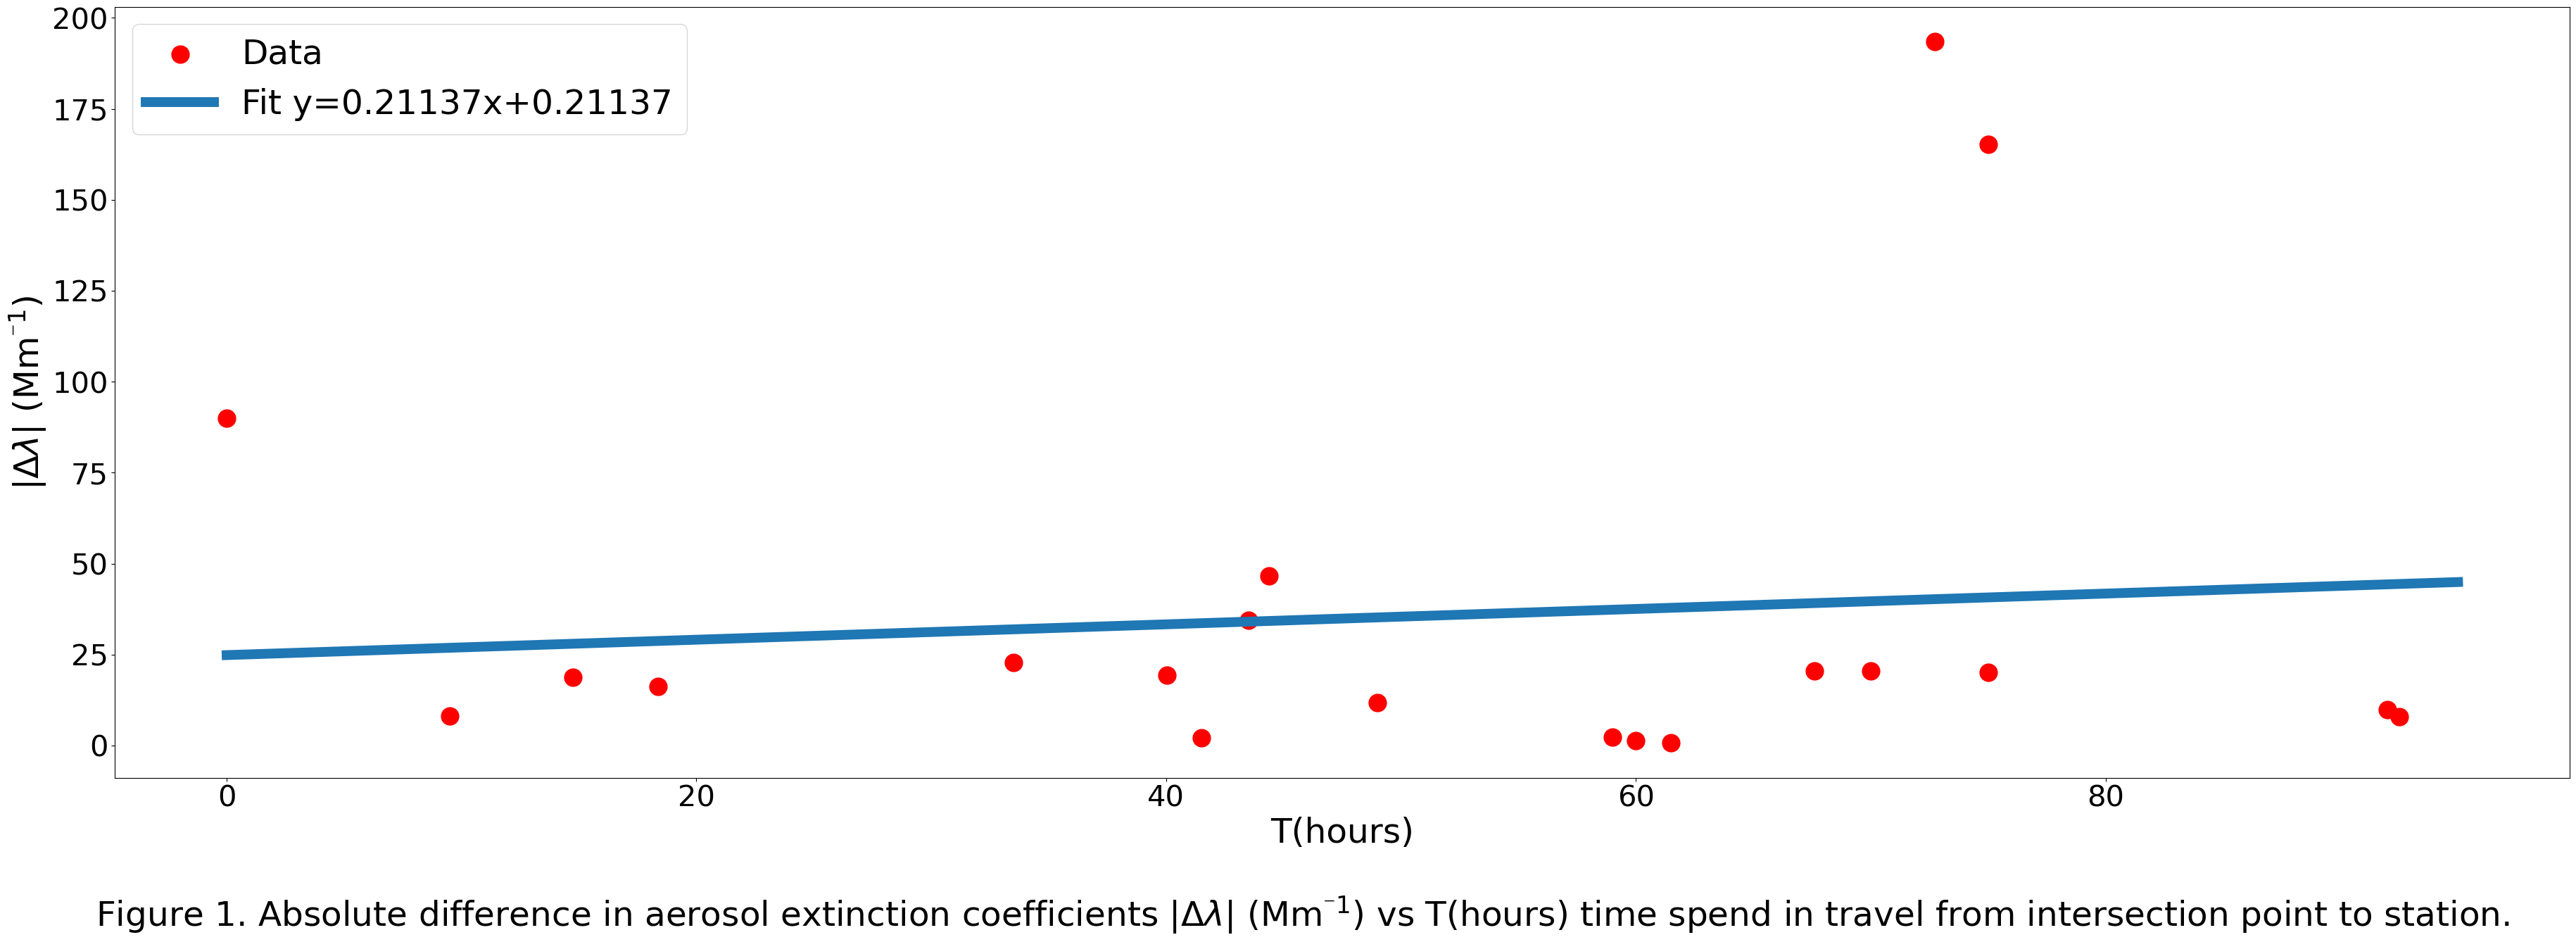

In [8]:
# Plotting reality check results
fig = plt.figure(1, figsize=[45,15])
ax = plt.subplot()
sc = ax.scatter(t,np.abs(dlambda),c="r",label="Data",s=20*4**2)
ax.plot(xn,yn,label="Fit y={0:.5f}x+{0:.5f}".format(results.slope,results.intercept),lw=10)
ax.tick_params(axis='both', which='major', labelsize=30)
plt.legend(loc="upper left",fontsize=35)
plt.xlabel("T(hours)",fontsize=35)
plt.ylabel(r"|$\Delta \lambda$| (Mm$^{⁻1}$)",fontsize=35)
txt = r"Figure 1. Absolute difference in aerosol extinction coefficients |$\Delta \lambda$| (Mm$^{⁻1})$ vs T(hours) time spend in travel from intersection point to station."
plt.figtext(0.5, 0.01,txt,horizontalalignment='center', fontsize=35)
fig.subplots_adjust(bottom=0.15) 
plt.show()

Aerosol extinction coefficients comparison is plotted.

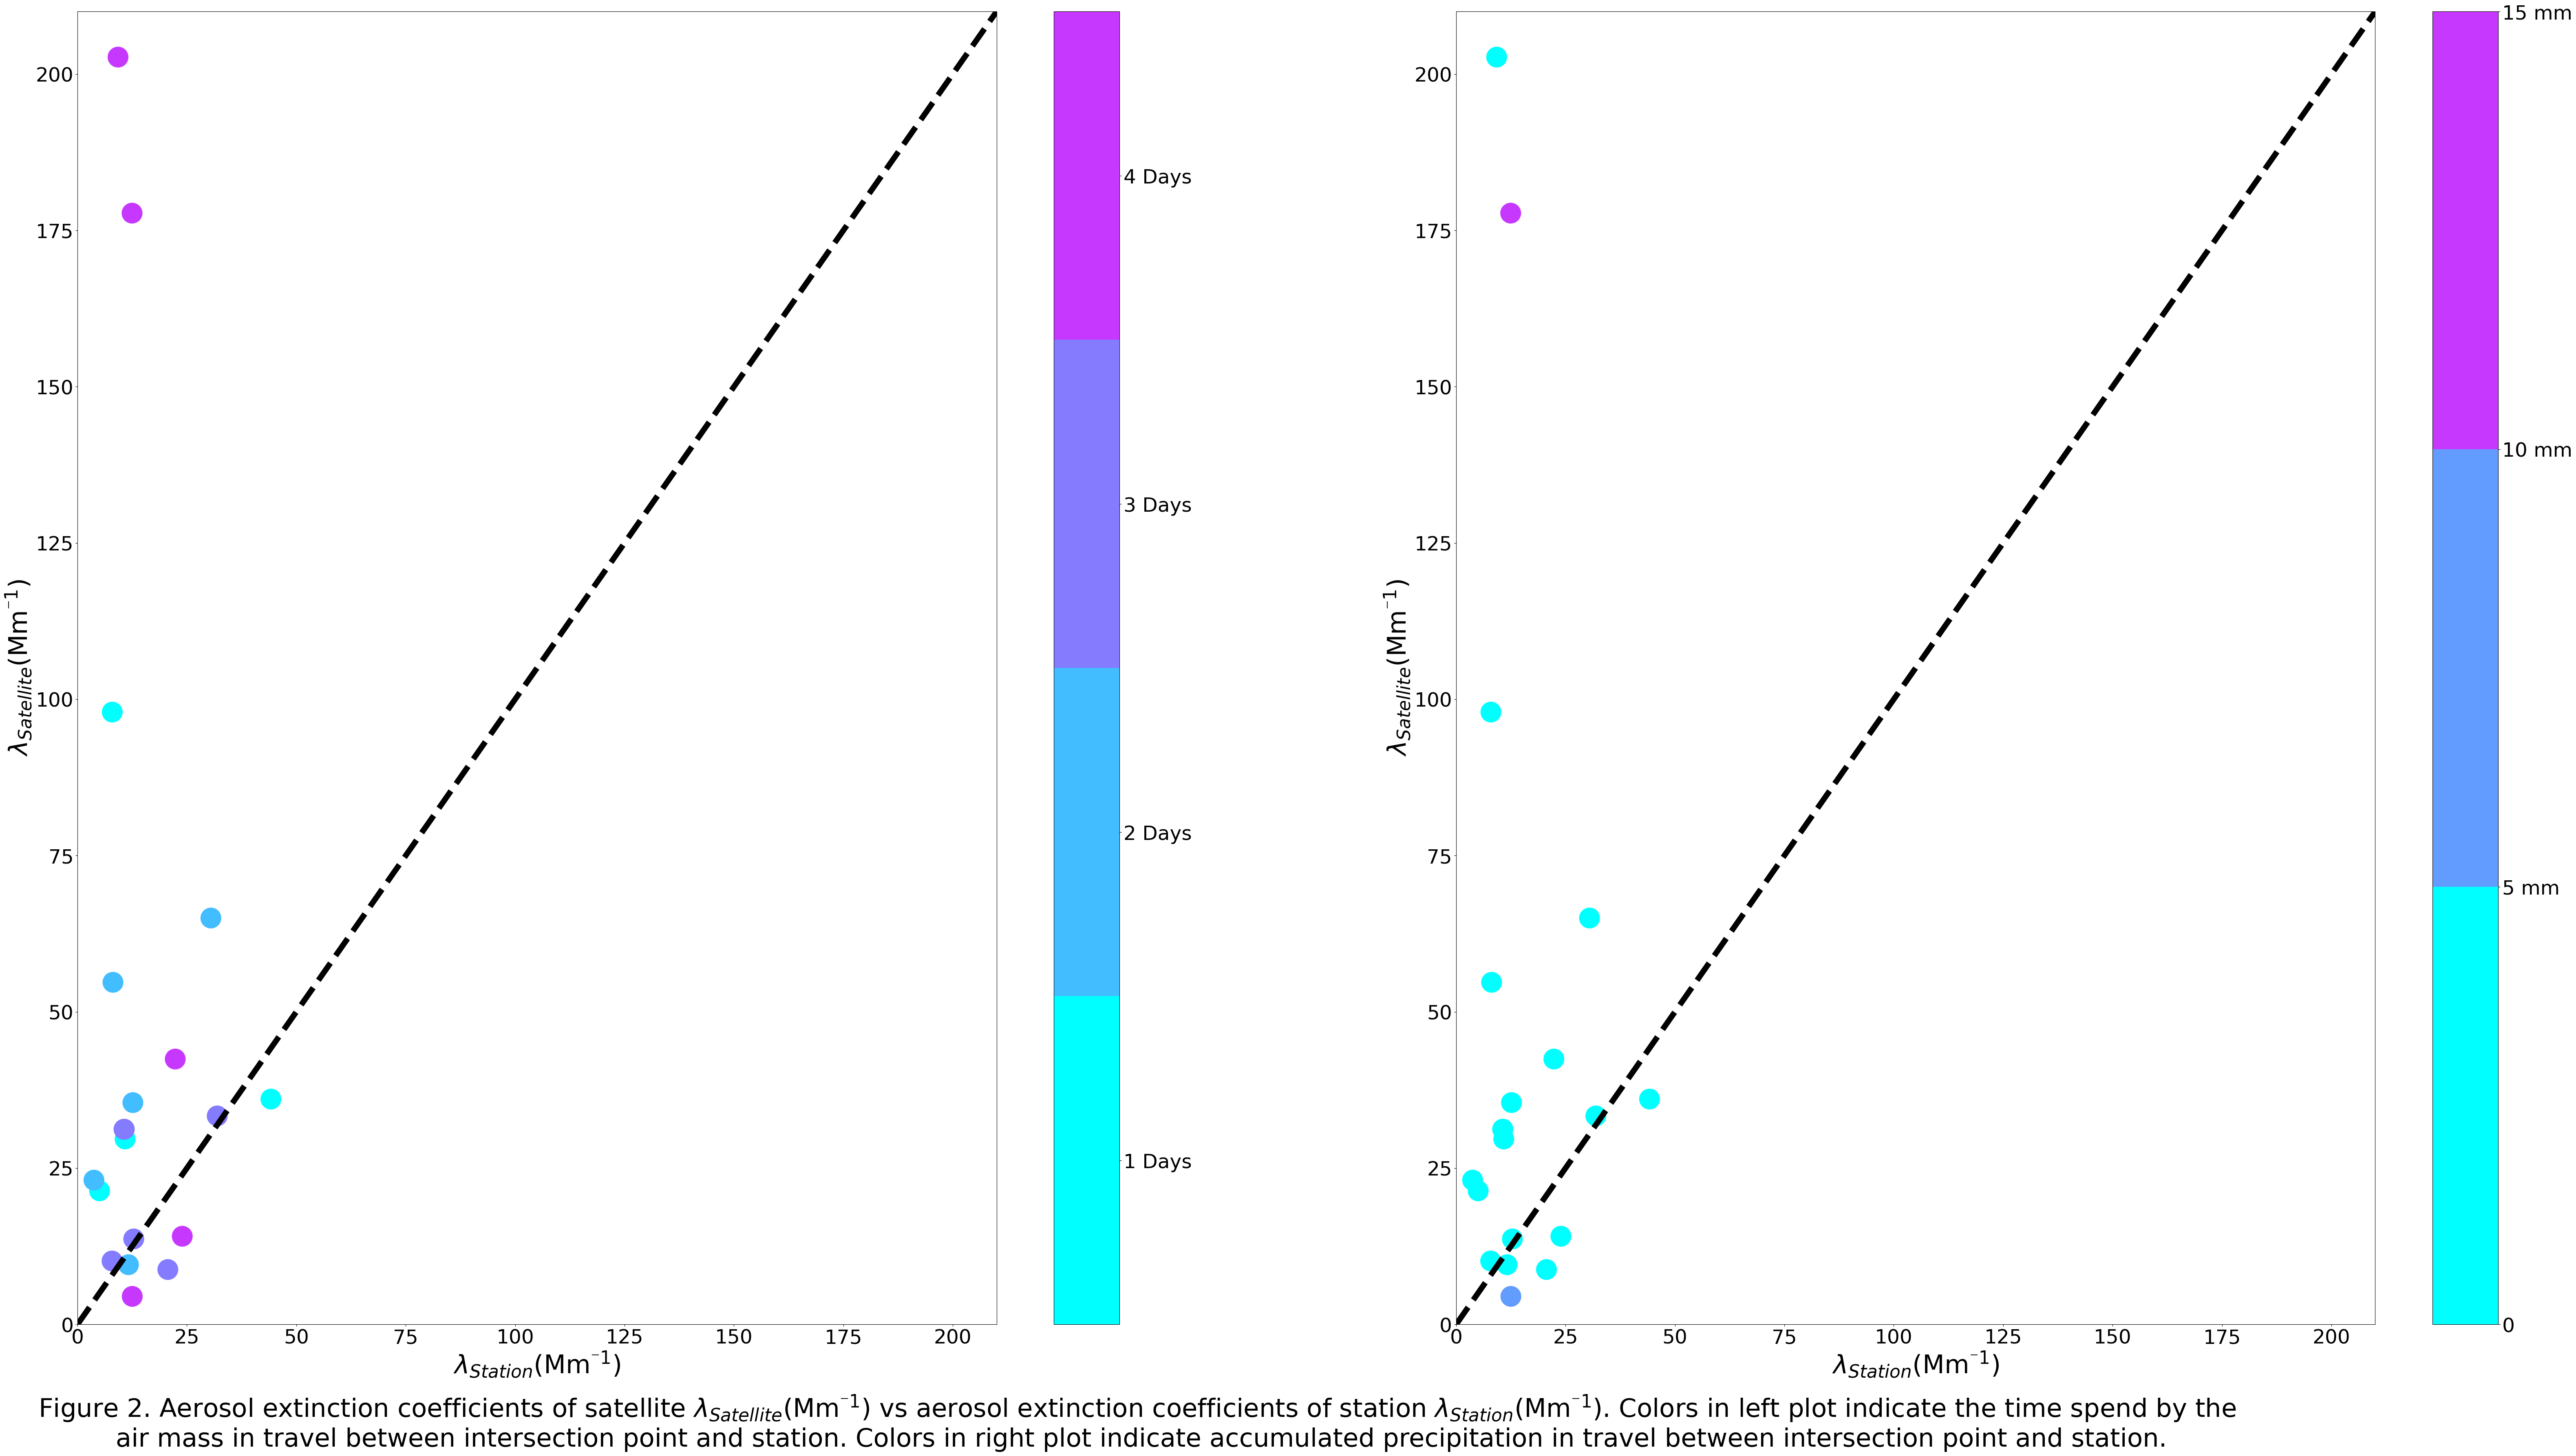

In [9]:
# Scattering comparison

fig = plt.figure(1, figsize=[80,40])
ax = plt.subplot(121)

bounds = np.array([1, 2, 3, 4, 5])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=200)
colormap = plt.get_cmap("cool")

ax.tick_params(axis='both', which='major', labelsize=35)
plt.ylabel(r"$\lambda_{Satellite}$(Mm$^{⁻1}$)",fontsize=45)
plt.xlabel(r"$\lambda_{Station}$(Mm$^{⁻1}$)",fontsize=45)
txt = "Figure 2. Aerosol extinction coefficients of satellite $\lambda_{Satellite}$(Mm$^{⁻1})$ vs aerosol extinction coefficients of station $\lambda_{Station}$(Mm$^{⁻1})$. Colors in left plot indicate the time spend by the\n air mass in travel between intersection point and station. Colors in right plot indicate accumulated precipitation in travel between intersection point and station."
plt.figtext(0.45, 0.0001,txt,horizontalalignment='center', fontsize=45)

ax.set_xlim([0, 210])
ax.set_ylim([0, 210])

lx = np.linspace(0,210)
ly = lx
ax.plot(lx,ly,color="k",linestyle='dashed',lw=10)

sc = ax.scatter(a_station_scatter_val,a_sat_scat_lidar,c=sta_traj_days,norm=norm,cmap=colormap,s=20*4**3)
cb = plt.colorbar(sc, ticks = np.array(range(0,5))+0.5)
cb.ax.set_yticklabels(["","1 Days","2 Days","3 Days","4 Days"],fontsize=35)



ax = plt.subplot(122)

bounds = np.array([1, 2, 3, 4])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=200)
colormap = plt.get_cmap("cool")

ax.tick_params(axis='both', which='major', labelsize=35)
plt.ylabel(r"$\lambda_{Satellite}$(Mm$^{⁻1}$)",fontsize=45)
plt.xlabel(r"$\lambda_{Station}$(Mm$^{⁻1}$)",fontsize=45)

ax.set_xlim([0, 210])
ax.set_ylim([0, 210])

lx = np.linspace(0,210)
ly = lx
ax.plot(lx,ly,color="k",linestyle='dashed',lw=10)

sc = ax.scatter(a_station_scatter_val,a_sat_scat_lidar,c=precipitation_gatecory,norm=norm,cmap=colormap,s=20*4**3)
cb = plt.colorbar(sc, ticks = np.array(range(0,4))+1)
cb.ax.set_yticklabels(["0","5 mm","10 mm","15 mm"],fontsize=35)


fig.subplots_adjust(bottom=0.075) 

plt.show()

An visual inspection of possible effects is done by plotting absolute AEC $|\Delta\lambda|$ vs accumulated precipitation. Two precipitation datasets were used. Time and distance was used as scatter plot color parameter.

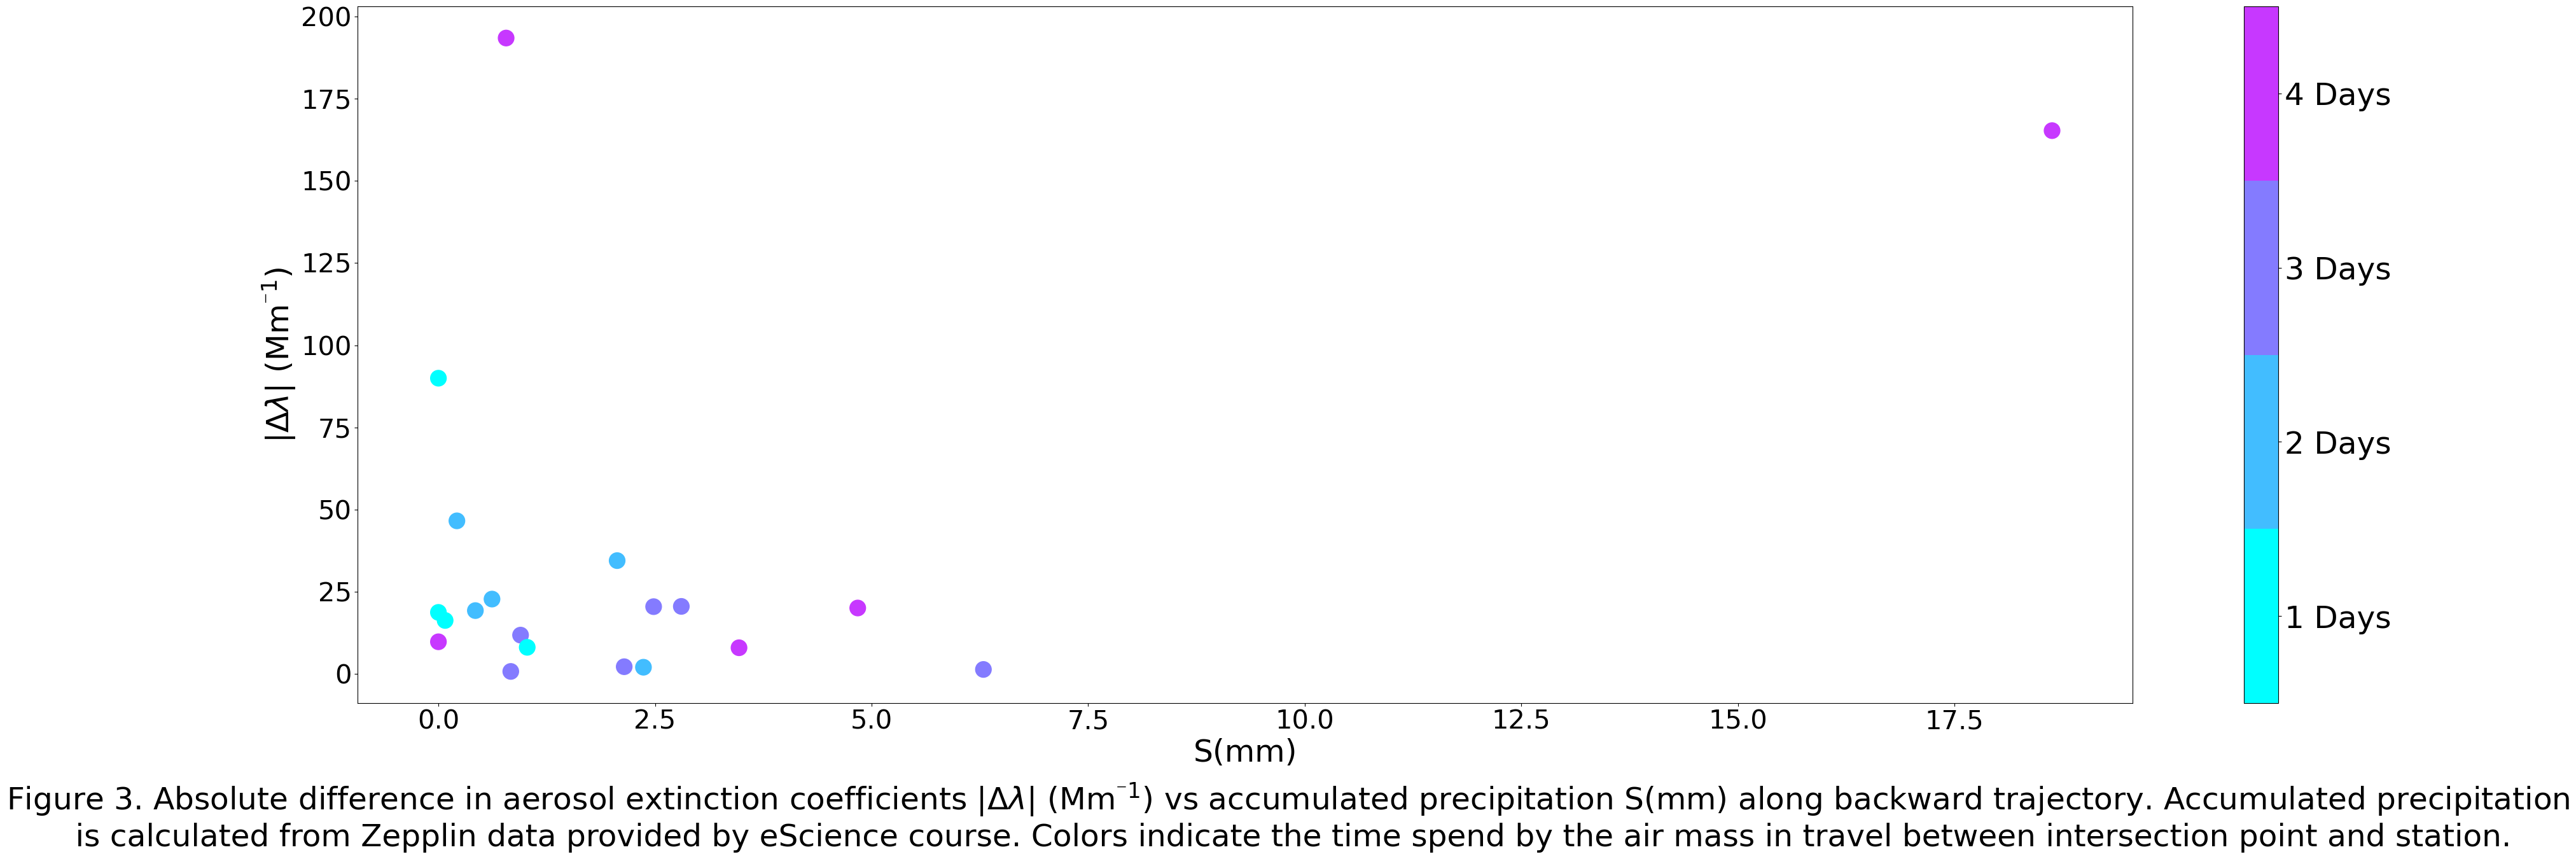

In [10]:
# Plotting results

fig = plt.figure(1, figsize=[45,15])
ax = plt.subplot()

bounds = np.array([1, 2, 3, 4, 5])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=200)
colormap = plt.get_cmap("cool")

ax.tick_params(axis='both', which='major', labelsize=30)
plt.xlabel("S(mm)",fontsize=35)
plt.ylabel(r"|$\Delta \lambda$| (Mm$^{⁻1}$)",fontsize=35)
txt = "Figure 3. Absolute difference in aerosol extinction coefficients |$\Delta \lambda$| (Mm$^{⁻1})$ vs accumulated precipitation S(mm) along backward trajectory. Accumulated precipitation\n is calculated from Zepplin data provided by eScience course. Colors indicate the time spend by the air mass in travel between intersection point and station."
plt.figtext(0.45, 0,txt,horizontalalignment='center', fontsize=35)

sc = ax.scatter(a_accumulated_percip,np.abs(delta_ext),c=sta_traj_days,norm=norm,cmap=colormap,s=20*4**2)
cb = plt.colorbar(sc, ticks = np.array(range(0,5))+0.5)
cb.ax.set_yticklabels(["","1 Days","2 Days","3 Days","4 Days"],fontsize=35)
fig.subplots_adjust(bottom=0.15) 
plt.show()

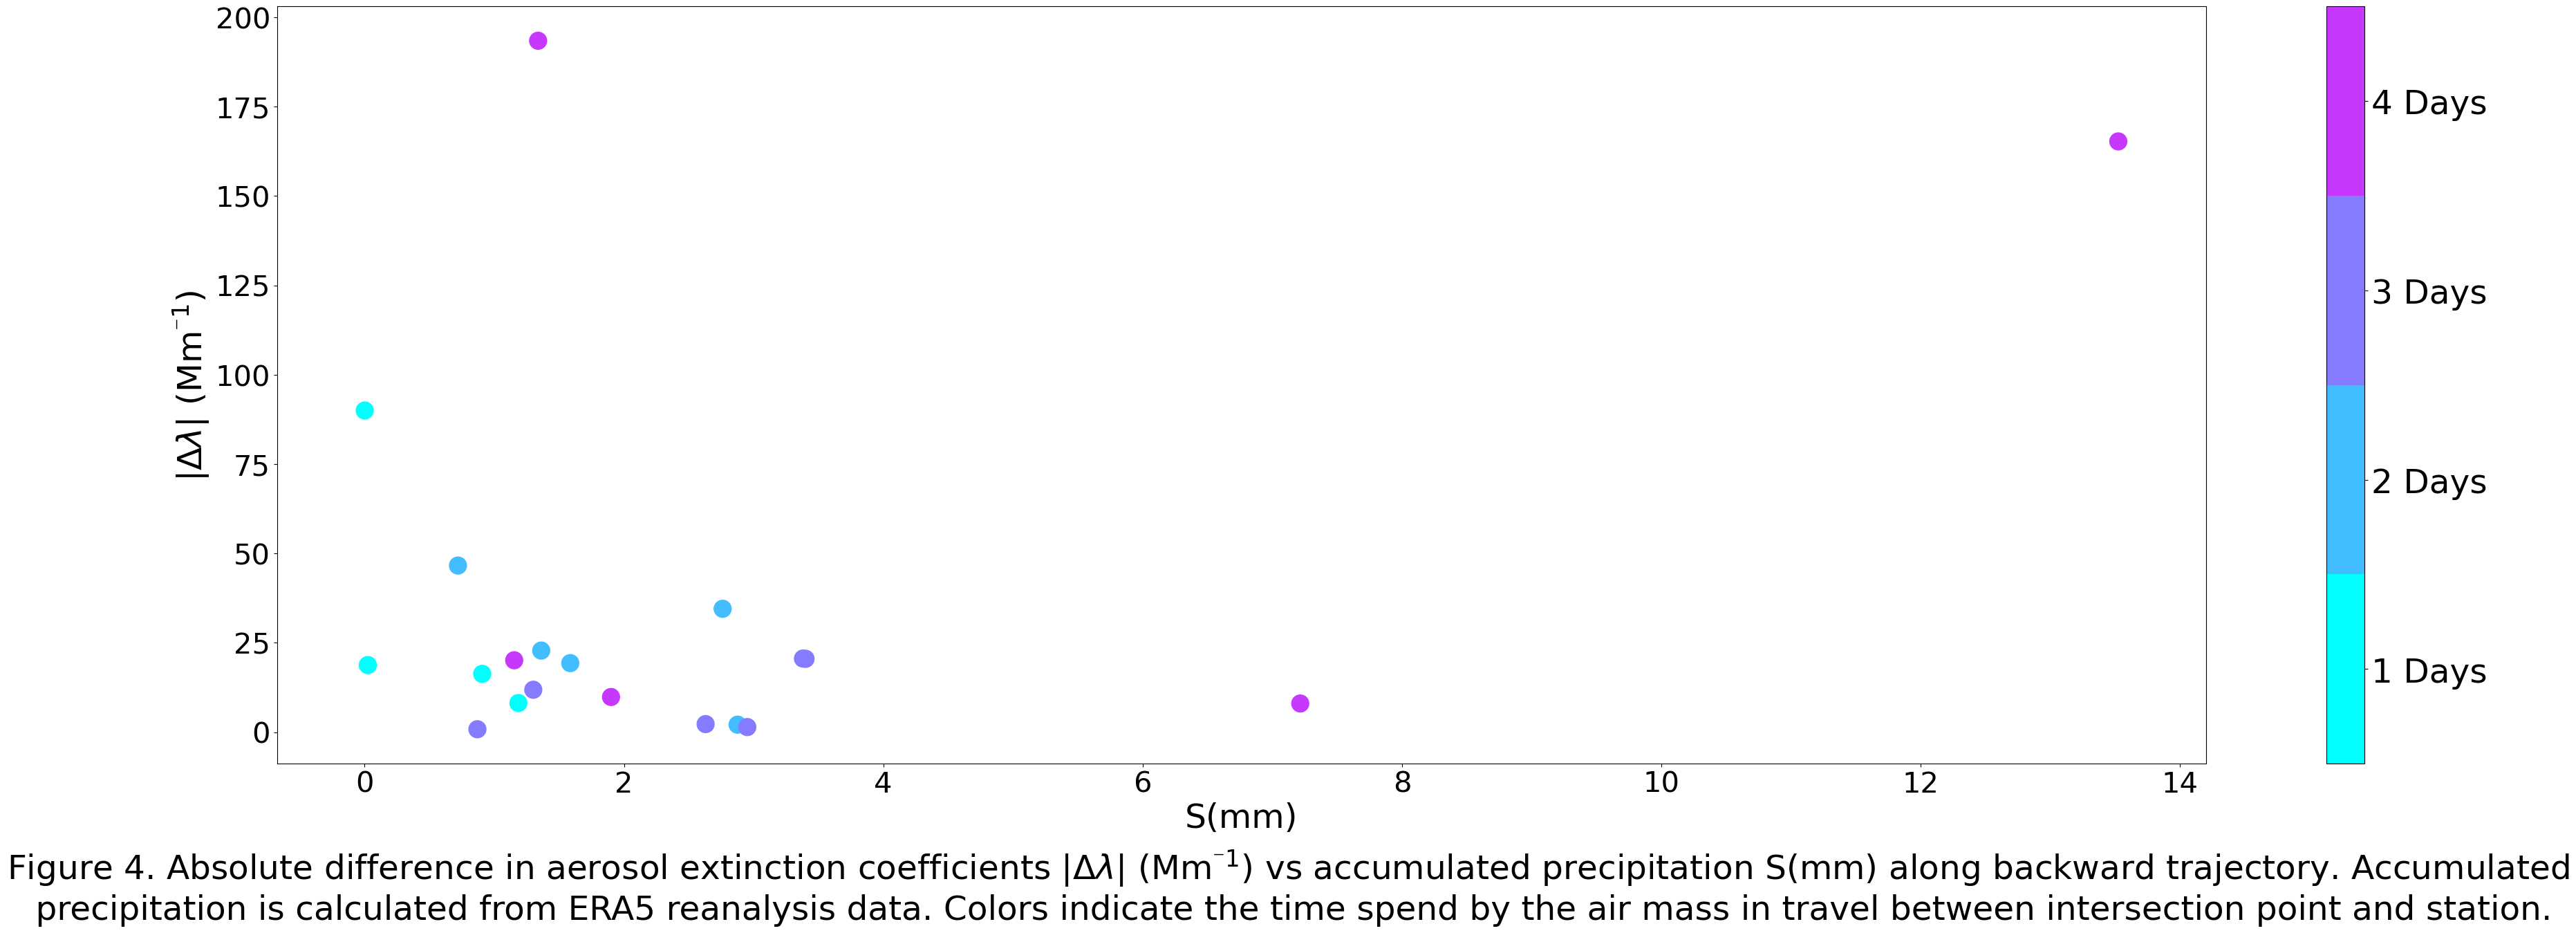

In [11]:
# Plotting results

fig = plt.figure(1, figsize=[45,15])
ax = plt.subplot()

bounds = np.array([1, 2, 3, 4, 5])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=200)
colormap = plt.get_cmap("cool")

ax.tick_params(axis='both', which='major', labelsize=30)
plt.xlabel("S(mm)",fontsize=35)
plt.ylabel(r"|$\Delta \lambda$| (Mm$^{⁻1}$)",fontsize=35)
txt = "Figure 4. Absolute difference in aerosol extinction coefficients |$\Delta \lambda$| (Mm$^{⁻1})$ vs accumulated precipitation S(mm) along backward trajectory. Accumulated\n precipitation is calculated from ERA5 reanalysis data. Colors indicate the time spend by the air mass in travel between intersection point and station."
plt.figtext(0.45, 0.0001,txt,horizontalalignment='center', fontsize=35)

sc = ax.scatter(a_accumulated_percip_era5,np.abs(delta_ext),c=sta_traj_days,norm=norm,cmap=colormap,s=20*4**2)
cb = plt.colorbar(sc, ticks = np.array(range(0,5))+0.5)
cb.ax.set_yticklabels(["","1 Days","2 Days","3 Days","4 Days"],fontsize=35)
fig.subplots_adjust(bottom=0.15) 
plt.show()

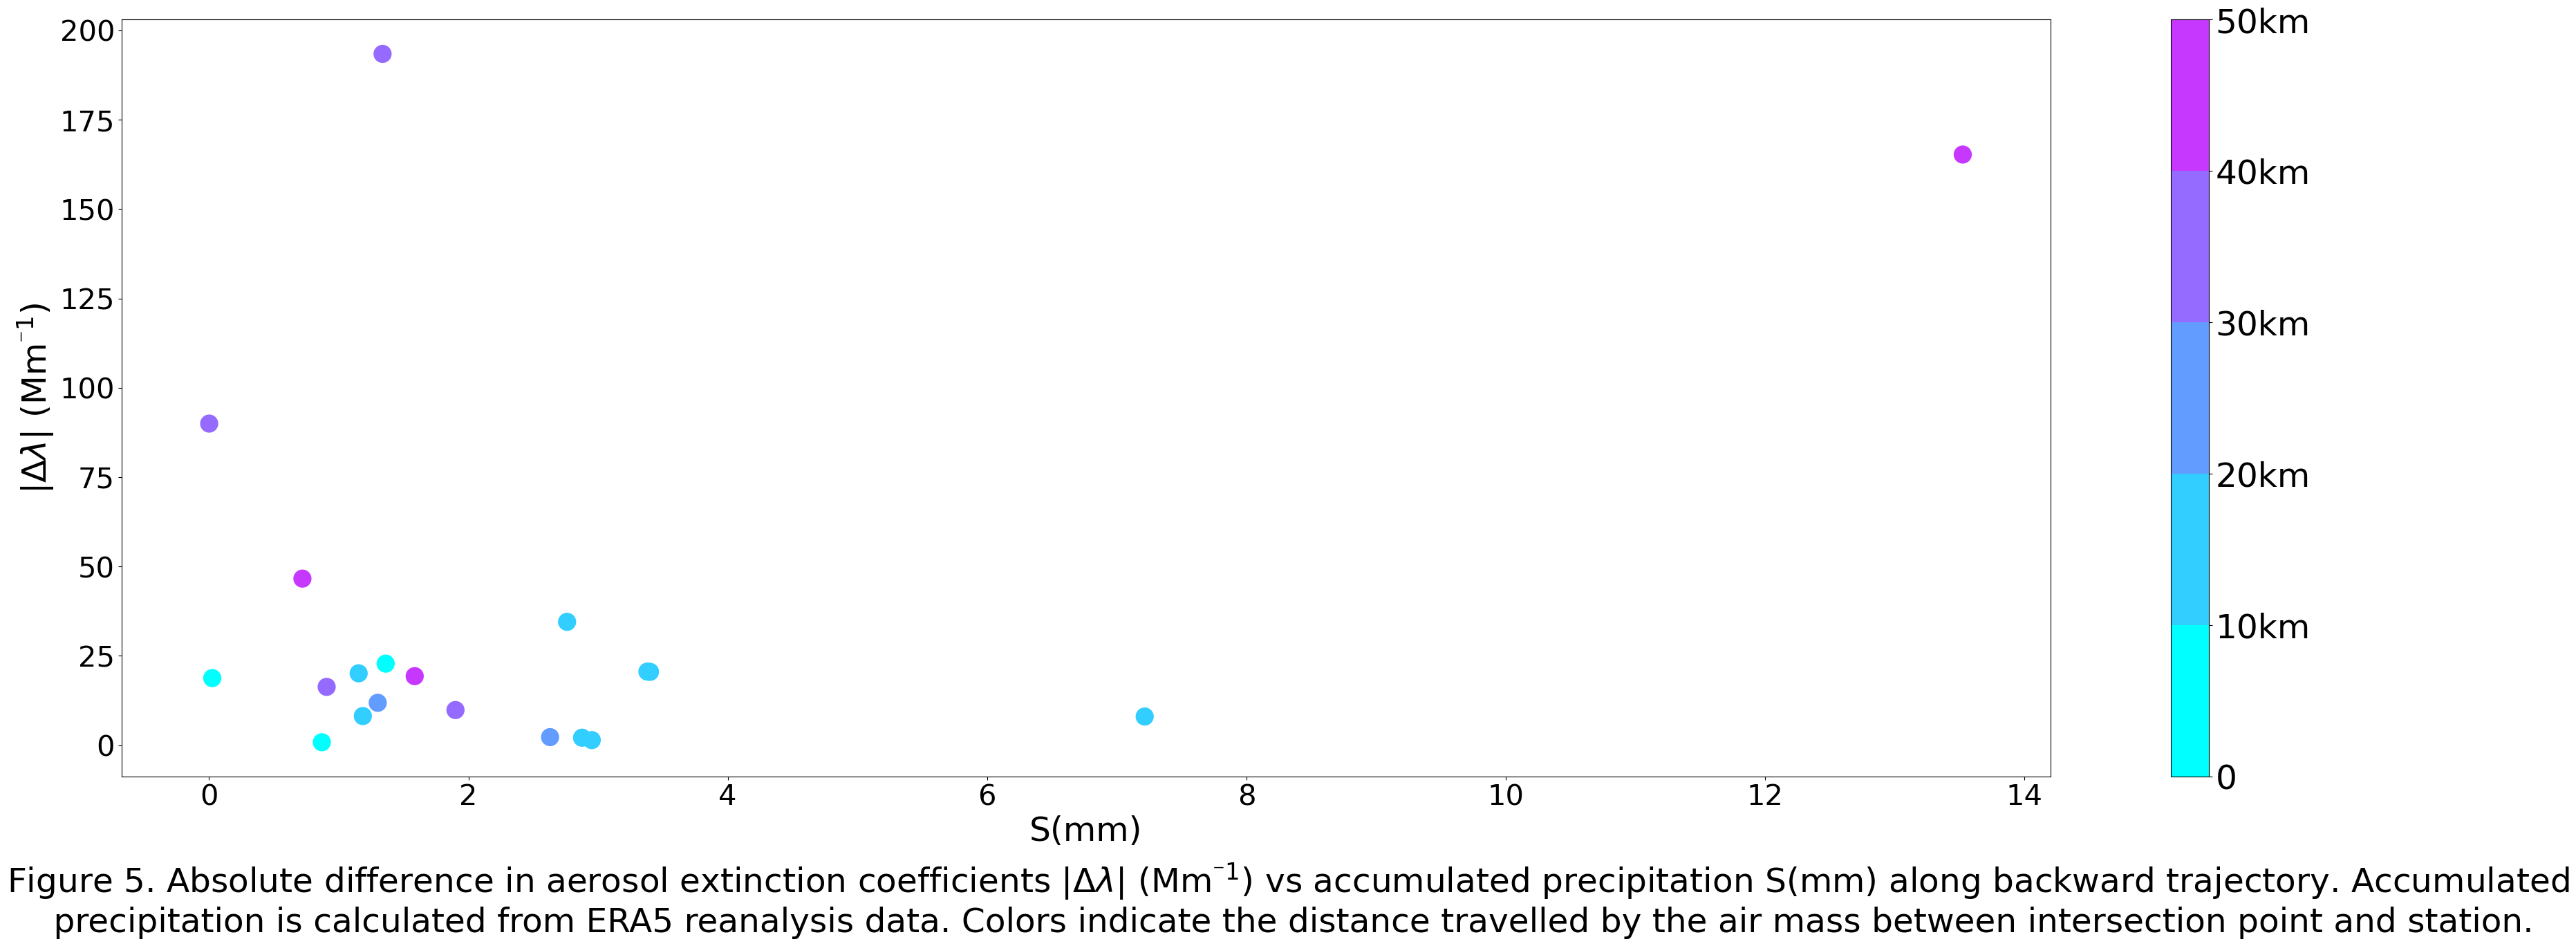

In [12]:
# Scattering comparison

fig = plt.figure(1, figsize=[45,15])
ax = plt.subplot()

bounds = np.array([1, 2, 3, 4, 5, 6])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=200)
colormap = plt.get_cmap("cool")

ax.tick_params(axis='both', which='major', labelsize=30)
plt.xlabel("S(mm)",fontsize=35)
plt.ylabel(r"|$\Delta \lambda$| (Mm$^{⁻1}$)",fontsize=35)
txt = "Figure 5. Absolute difference in aerosol extinction coefficients |$\Delta \lambda$| (Mm$^{⁻1})$ vs accumulated precipitation S(mm) along backward trajectory. Accumulated\n precipitation is calculated from ERA5 reanalysis data. Colors indicate the distance travelled by the air mass between intersection point and station."
plt.figtext(0.5, 0.0001,txt,horizontalalignment='center', fontsize=35)

sc = ax.scatter(a_accumulated_percip_era5,np.abs(delta_ext),c=sta_traj_length_gatecory,norm=norm,cmap=colormap,s=20*4**2)
cb = plt.colorbar(sc, ticks = np.array(range(0,6))+1)
cb.ax.set_yticklabels(["0","10km","20km","30km","40km","50km"],fontsize=35)
fig.subplots_adjust(bottom=0.15) 
plt.show()

### 4 Discussion

The amount of usable data to performe statistics in this study is very limited. This is due to the fact that CALLIPSO satellite and air mass backward trajectory colocation calculation takes long time to run and only year 2013 was processed. Other limiting factor is the amount of detected particulates in measurements. In section 2.6 are presented the amount of usable data to performe statistics.

In figures 1 and 2 data is plotted to see if it is possible to conclude something from further analysis. In figure 1 an increasing trend should be detected with an increasing spread. This is a reasonable assumption because a longer time between measurements should indicate more possible changes in measured values. An trend is found but it is not significant. This is probably due to a small amount of data. From figure 2 we can inspect whether the data looks reasonable. Majority of data with small aerosol extinction coefficients align with linear line. From two large satellite aerosol extinction coefficients that have travelled 4 days we can deduce that something has happened in between measurements. The other has precipitated as can be seen from the right plot. In the case of the second point, probably other effects than precipitation would explain the change better.

In figures 3, 4 and 5 is plotted possible ways to inspect effects of precipitation. Unfortunately nothing can be seen from these plots with this amount of data. With higher amounts of data some clusters would probably emerge. In future if more data would be collected some machine learning methods could also be utilized. Also more ERA5 reanalysis variables could be collected and used in analysis.

### 5 Conclusion

Due to the small amount of usable data for statistics, it is really difficult to make any reliable estimates of relationship between precipitation and change in aerosol extinction coefficient between satellite and station measurements. It can be speculated that in future if more data is collected some trends and clusters would emerge in to those previously mentioned plots. Also some more variables and advanced methods could be included.

### 6 References

P. Zieger , R. Fierz-Schmidhauser , M. Gysel , J. Ström , S. Henne , K. E. Yttri , U. Baltensperger , and E. Weingartner, *Effects of relative humidity on aerosol light scattering in the Arctic*, Atmospheric Chemistry and Physics, 2010  

Data provider [icare](https://www.icare.univ-lille.fr/)  
Zepplin lidar data [Aerosol light scattering properties at Zeppelin Observatory, Svalbard, 1999⁠ – ⁠2016, with back trajectory analysis parameters](https://bolin.su.se/data/zeppelin-aerosol-light-scattering-1)  
Some time conversion were done with [ccplot pakage](https://github.com/peterkuma/ccplot).  
Some time conversion were done with [Grain pakage](https://github.com/nbearson/grain).  



### Appendix A: Code to colocate intersection points of CALIPSO satellite track and air mass backward trajectories of Zepplin measurement station

``` 
from pyhdf.SD import SD, SDC

import numpy as np
import glob
import pickle
import xarray as xr
import pandas as pd

from grain import Grain
from datetime import datetime, timedelta


def open_hdf(path):
    file = SD(path, SDC.READ)
    datasets_dic = file.datasets()

    time = np.expand_dims(np.array(file.select('Time')),axis=1)
    lat = np.expand_dims(np.array(file.select("Latitude")),axis=1)
    long = np.expand_dims(np.array(file.select("Longitude")),axis=1)

    data = np.concatenate((time, lat, long), axis=1)

    return data



def tai_2_utc(vec):
    vec = np.squeeze(vec)
    g = Grain()
    MODIS_EPOCH = datetime(1993, 1, 1)
    time_list = list()
    
    for i in range(np.size(vec)):
         time_list.append(np.datetime64(g.tai2utc(vec[i],MODIS_EPOCH)))
    
    return np.array(time_list)


def calc_dist_two_points(lat1,lon1,lat2,lon2):
    R = 6371*1e3
    p1 = lat1*np.pi/180
    p2 = lat2*np.pi/180
    dp = (lat2-lat1)*np.pi/180
    dL = (lon2-lon1)*np.pi/180
    a = np.sin(dp/2)*np.sin(dp/2) + np.cos(p1)*np.cos(p2)*np.sin(dL/2)*np.sin(dL/2)
    c = 2*np.arctan2(np.sqrt(a),np.sqrt(1-a))
    return R*c


def time_interval_halfing_check(traj_val, sat_time_vec):
    for i in range(sat_time_vec.size):
        if i == 0:
            t_max = np.max(sat_time_vec)
            t_min = np.min(sat_time_vec)
            t_med = sat_time_vec[int(np.mean((np.where(sat_time_vec==t_min), np.where(sat_time_vec==t_max))))]
        
        t_diff_min_interval = np.abs((traj_val - t_min)/np.timedelta64(1, 's'))
        t_diff_max_interval = np.abs((traj_val - t_max)/np.timedelta64(1, 's'))
        
        if t_diff_min_interval < t_diff_max_interval:
            t_max = t_med
            t_min = t_min
            t_med = sat_time_vec[int(np.mean((np.where(sat_time_vec==t_min), np.where(sat_time_vec==t_max))))]
            #print("min")
        else:
            t_max = t_max
            t_min = t_med
            t_med = sat_time_vec[int(np.mean((np.where(sat_time_vec==t_min), np.where(sat_time_vec==t_max))))]
            #print("max")
            
        if (t_max == t_min) or (t_max == t_med) or (t_min == t_med):
            #print(t_max)
            #print(t_med)
            #print(t_min)
            #print(traj_val)
            sat_time_point_ind = np.where(sat_time_vec == t_med)
            break
            
    return t_med, sat_time_point_ind


print("Loading station data")
traj_paths = "/data/ds_zeppelin_2010_2019.nc"
station_data = xr.open_dataset(traj_paths)
station_data = station_data.sel(time=slice('2013-01-01', '2014-01-01'))
print("Done\n")

# Check file times
time_treshold = 2*60*60 # In Seconds
distance_treshold = 50000 # In Meters

#Lists for saving
sat_time_list = list()
sat_lati_list = list()
sat_long_list = list()
sta_time_list = list()
sta_lati_list = list()
sta_long_list = list()
traj_list = list()

general_data_list = list()

print("Starting colocation calculation...")

file_count = len(glob.glob('/calltrack/CALTRACK-*.hdf'))

for jdx, name in enumerate(glob.glob('/calltrack/CALTRACK-*.hdf')):
    #print(idx)
    sat_track = name
    satellite_data = open_hdf(sat_track)

    sat_time_vec = tai_2_utc(satellite_data[:,0])

    print("Done: " + str(jdx+1) + "/" + str(file_count))

    something_found = False
    
    for idx, date_time in enumerate(station_data["time"].values):
    
        #print("Done: " + str(idx) + "/" + str(station_data["time"].values.size))
    
        min_d_sta = date_time - np.timedelta64(4*24, 'h')
        max_d_sta = date_time
        min_d_sat = np.min(sat_time_vec)
        max_d_sat = np.max(sat_time_vec)
    
        #tällä karsitaan ne joissa aika ikkunat ei risteä
        if ((min_d_sta < min_d_sat) and (min_d_sat < max_d_sta)) or ((min_d_sta < max_d_sat) and (max_d_sat < max_d_sta)):
        
            for h in range(0,96):
                closest_time_point, closest_point_sat_ind = time_interval_halfing_check(date_time - np.timedelta64(h, 'h'), sat_time_vec)
                #print(closest_time)
            
                # Tässä lasketaan aika tresholdi
                if np.abs(((date_time - np.timedelta64(h, 'h')) - closest_time_point)/np.timedelta64(1, 's')) < time_treshold:
                    #print(date_time)
                    #print(h)
                    #print(date_time - np.timedelta64(h, 'h'))
                    #print(closest_time_point)
                    #print("-------------------------------------------------------------------------")
                
                    lat1 = station_data["x"].isel(time=idx,time_traj=h).values
                    lon1 = station_data["y"].isel(time=idx,time_traj=h).values
                    lat2 = satellite_data[closest_point_sat_ind,1]
                    lon2 = satellite_data[closest_point_sat_ind,2]
                
                    if calc_dist_two_points(lat1,lon1,lat2,lon2) < distance_treshold:
                        something_found = True
                        print("\nFound point: ")
                        print(lat1)
                        print(lat2)
                        print(lon1)
                        print(lon2)
                        print(closest_time_point)
                        print(h)
                        print(date_time)
                        print("\n")
                        
                        sat_time_list.append(closest_time_point)
                        sat_lati_list.append(lat2)
                        sat_long_list.append(lon2)
                        sta_time_list.append(date_time)
                        sta_lati_list.append(lat1)
                        sta_long_list.append(lon1)
                        traj_list.append(h)
    
    if something_found:
        general_data_list.append(list([sat_time_list, sat_lati_list, sat_long_list, sta_time_list, sta_lati_list, sta_long_list, traj_list]))
    
        save_data(general_data_list,"/new_coloc_calc/" + str(jdx+1))


print("\n\nAll done!")

```

### Appendix B1: Download CALIPSO measurements matching colocation points
```
# Pakages
from pyhdf.SD import SD, SDC
import os

import numpy# as numpy
import glob
import pickle
import xarray as xr
import pandas as pd

from datetime import datetime, timedelta


def open_data(file_name):
    with open(file_name, 'rb') as handle:
        data = pickle.load(handle)

    return data


# Main program
download_list_path = "/home/vaisanea/Desktop/sweden_stuff/2996.txt"

data = open_data(download_list_path)

sat_time_list = data[0]

for time_dates in sat_time_list[0]:
    d = time_dates
    #print(d.dtype)
    d = d.astype(datetime)
    Y = d.strftime("%Y")
    M = d.strftime("%m")
    D = d.strftime("%d")
    H = d.strftime("%H")
    dm1h = d - timedelta(hours = 1)
    HM1 = dm1h.strftime("%H")
    DM1 = dm1h.strftime("%d")
    
    icare_main_path = "/SPACEBORNE/CALIOP/05kmAPro.C4/2013/"
    icare_path = "2013_" + M + "_" + D + "/"

    file_name_basic = "CAL_LID_L2_05kmAPro-Standard-V4-20.2013-" + M + "-" + D + "T" + H + "*.hdf"
    file_name_minus = "CAL_LID_L2_05kmAPro-Standard-V4-20.2013-" + M + "-" + DM1 + "T" + HM1 + "*.hdf"
    
    compined_path_basic = icare_main_path + icare_path + file_name_basic
    compined_path_minus = icare_main_path + icare_path + file_name_minus
    
    os.system("wget -nv -r -nc -np -nH --cut-dirs=3 ftp://ftp.icare.univ-lille1.fr{} --accept=hdf -e robots=off --level=0".format(compined_path_basic))
    os.system("wget -nv -r -nc -np -nH --cut-dirs=3 ftp://ftp.icare.univ-lille1.fr{} --accept=hdf -e robots=off --level=0".format(compined_path_minus))

print("Done!")


```

### Appendix B2: Code to get the Lidar values of Zepplin station and CALIPSO satellite from the colocated intersection points

```
import numpy as np
import pandas as pd
import pickle

from pyhdf.SD import SD, SDC
from datetime import datetime, timedelta

import datetime as dt
import pytz
import glob



def set_vec_to_datetime64(vec):
    arr = list()
    for time_date in vec:
        arr.append(np.datetime64(time_date))
    return np.array(arr)


def calipso_time2dt(time):
    d = int(time % 100)
    m = int((time - d) % 10000)
    y = int(time-m-d)
    return dt.datetime(2000 + y//10000, m//100, d) + dt.timedelta(time % 1)


def calipso_vec_2_np_datetime64(vec):
    arr = list()
    for time_date in vec:
        arr.append(np.datetime64(calipso_time2dt(time_date)))
    return np.array(arr)


def fix_the_sat_coord_list(coord_list):
    new_list = list()
    for item in coord_list:
        new_list.append(item[0][0])
    return new_list


# Opening station data
station_path = "/data/ACP_2020_HeslinRees.csv"

#station_data = np.genfromtxt(path, delimiter=',')

station_data = pd.read_csv(station_path, sep=",")

station_data.columns.values[0] = "time"

sta_scat = np.array(station_data["scat550"])
sta_rH = np.array(station_data["rH"])

sta_time = station_data["time"]
sta_time = set_vec_to_datetime64(sta_time)

time_min = np.datetime64("2013-01-01")
time_max = np.datetime64("2014-01-01")

time_mask_min = sta_time >= time_min
time_mask_max = sta_time <= time_max
time_mask = time_mask_min & time_mask_max

sta_time = sta_time[time_mask]
sta_scat = sta_scat[time_mask]
sta_rH = sta_rH[time_mask]


# Open list of colocated points
download_list_path = "data/4140.txt"
data = open_data(download_list_path)
data = data[0]

# <----> VARS
sat_time_inter = data[0]
sat_lati_inter = fix_the_sat_coord_list(data[1])
sat_long_inter = fix_the_sat_coord_list(data[2])

sta_time_inter = data[3]
sta_lati_inter = data[4]
sta_long_inter = data[5]
sta_traj_inter = data[6]


# Find station scattering
station_time_val = list()
station_scatter_val = list()
station_rh_val = list()

for sta_time_point in sta_time_inter:
    sta_time_min = sta_time_point - np.timedelta64(1, 'h')
    sta_time_max = sta_time_point + np.timedelta64(1, 'h')
    
    time_window_min = sta_time >= sta_time_min
    time_window_max = sta_time <= sta_time_max
    
    time_window = time_window_min & time_window_max
    
    station_time_val.append(sta_time_point)
    station_scatter_val.append(np.mean(sta_scat[time_window]))
    station_rh_val.append(np.mean(sta_rH[time_window]))
    
station_time_val = np.array(station_time_val)
station_scatter_val = np.array(station_scatter_val)
station_rh_val = np.array(station_rh_val)


# Find satellite scattering

# Opening satellite data
lidar_file_path = "/data/lidar/2013/"
file_name = "CAL_LID_L2_05kmAPro-Standard-V4-20."

sat_time_lidar = list()
sat_lati_lidar = list()
sat_long_lidar = list()
sat_scat_lidar = list()
sat_rh_lidar = list()

for satellite_time in sat_time_inter:
    #print(satellite_time)
    satellite_time_s = satellite_time.astype(datetime)
    
    Yn0 = satellite_time_s.strftime("%Y")
    mn0 = satellite_time_s.strftime("%m")
    dn0 = satellite_time_s.strftime("%d")
    hn0 = satellite_time_s.strftime("%H")
    
    neg_satellite_time = satellite_time_s - timedelta(hours = 1)
    
    Yn1 = neg_satellite_time.strftime("%Y")
    mn1 = neg_satellite_time.strftime("%m")
    dn1 = neg_satellite_time.strftime("%d")
    hn1 = neg_satellite_time.strftime("%H")
    
    time_str_n0 = "{}-{}-{}T{}*.hdf".format(Yn0,mn0,dn0,hn0)
    time_str_n1 = "{}-{}-{}T{}*.hdf".format(Yn1,mn1,dn1,hn1)
    
    n0_lidar_data_path = lidar_file_path + file_name + time_str_n0
    n1_lidar_data_path = lidar_file_path + file_name + time_str_n1
    
    n0_time_list = glob.glob(n0_lidar_data_path)
    n1_time_list = glob.glob(n1_lidar_data_path)
    
    path_list = n0_time_list + n1_time_list
    
    for idx, sat_flight in enumerate(path_list):
        if idx == 0:
            sat_time, sat_lati, sat_long, sat_scat, sat_rh = open_hdf(sat_flight)
        else:
            sat_time_p, sat_lati_p, sat_long_p, sat_scat_p, sat_rh_p = open_hdf(sat_flight)
            
            sat_time = np.concatenate((sat_time,sat_time_p),axis = 0)
            sat_lati = np.concatenate((sat_lati,sat_lati_p),axis = 0)
            sat_long = np.concatenate((sat_long,sat_long_p),axis = 0)
            sat_scat = np.concatenate((sat_scat,sat_scat_p),axis = 0)
            sat_rh = np.concatenate((sat_rh,sat_rh_p),axis = 0)
    
    satellite_time_min = satellite_time.astype(datetime) - timedelta(seconds = 0.5)
    satellite_time_max = satellite_time.astype(datetime) + timedelta(seconds = 0.5)
    
    time_inds_min = sat_time >= satellite_time_min
    time_inds_max = sat_time <= satellite_time_max
    
    time_inds = time_inds_min & time_inds_max
    
    if np.sum(time_inds) > 1:
        sat_time = sat_time[time_inds][0]
        sat_lati = sat_lati[time_inds][0]
        sat_long = sat_long[time_inds][0]
        sat_scat = sat_scat[time_inds][0]
        sat_rh = sat_rh[time_inds][0]
    else:
        sat_time = sat_time[time_inds][0]
        sat_lati = sat_lati[time_inds][0]
        sat_long = sat_long[time_inds][0]
        sat_scat = np.nanmean(sat_scat[time_inds])
        sat_rh = np.nanmean(sat_rh[time_inds])   
    
    #print(sat_scat)
    sat_time_lidar.append(sat_time)
    sat_lati_lidar.append(sat_lati)
    sat_long_lidar.append(sat_long)
    sat_scat_lidar.append(sat_scat)
    sat_rh_lidar.append(sat_rh)

# <----> VARS
sat_time_lidar = np.array(sat_time_lidar)
sat_lati_lidar = np.array(sat_lati_lidar)
sat_long_lidar = np.array(sat_long_lidar)
sat_scat_lidar = np.array(sat_scat_lidar)
sat_rh_lidar = np.array(sat_rh_lidar)

print("\n-----------------")
print(np.count_nonzero(np.isnan(sat_scat_lidar)))

colocated_data = list([sat_time_inter, sat_lati_inter, sat_long_inter, sta_time_inter, sta_lati_inter, sta_long_inter, sta_traj_inter, station_time_val, station_scatter_val, station_rh_val, sat_time_lidar, sat_lati_lidar, sat_long_lidar, sat_scat_lidar, sat_rh_lidar])
save_data(colocated_data,"/colocated_data")

```

### Appendix C: Code to collect ERA5 total percipitation along the backward trajectories of Zepplin station

```
import numpy as np
import pickle

import xarray as xr

from netCDF4 import Dataset
from datetime import datetime, timedelta


def retrieve_percipitation_from_point(tim,lat,lon):
    data_folder_path = "/final_analysis/data/"

    if tim >= 120:
        file_name = "adaptor.mars.internal-1668684558.7529833-28771-1-796281a3-a915-4e78-8c1d-074f338bc79c.nc"
        tim = tim - 120
    else:
        file_name = "adaptor.mars.internal-1668696485.6576734-8134-11-5640a024-1804-4763-a333-daec3f04a65e.nc"
    
    with Dataset(data_folder_path + file_name) as data_grip:
        tp = data_grip.variables["tp"][tim][lat][lon]
    
    return tp


def create_time_mask(time_point, treshold, time_data):
    time_lim_min = time_point - np.timedelta64(treshold, "m")
    time_lim_max = time_point + np.timedelta64(treshold, "m")
    
    time_mask_lim_min = time_data >= time_lim_min
    time_mask_lim_max = time_data <= time_lim_max
    
    time_mask = time_mask_lim_min & time_mask_lim_max
    return time_mask


def create_coord_mask(coord,treshold,data):
    coord_min = coord - treshold
    coord_max = coord + treshold

    mask_min = data >= coord_min
    mask_max = data <= coord_max
    
    mask = mask_min & mask_max
    return mask


traj_paths = "/final_analysis/data/ds_zeppelin_2010_2019.nc"
zeppelin_data = xr.open_dataset(traj_paths)
zeppelin_data = zeppelin_data.sel(time=slice('2013-01-01', '2014-01-01'))


# Weather reanalysis data
data_folder_path = "/final_analysis/data/"
file_name_1 = "adaptor.mars.internal-1668684558.7529833-28771-1-796281a3-a915-4e78-8c1d-074f338bc79c.nc"
file_name_2 = "adaptor.mars.internal-1668696485.6576734-8134-11-5640a024-1804-4763-a333-daec3f04a65e.nc"

with Dataset(data_folder_path + file_name_1) as data_grip:
    lon = data_grip.variables["longitude"][:]
    lat = data_grip.variables["latitude"][:]
    time1 = data_grip.variables["time"][:]

time_list_1 = list()
for hour_point in time1:
    time_list_1.append(np.datetime64(datetime(1900,1,1) + timedelta(hours=int(hour_point))))
time1 = np.array(time_list_1)

with Dataset(data_folder_path + file_name_2) as data_grip:
    time2 = data_grip.variables["time"][:]

time_list_2 = list()
for hour_point in time2:
    time_list_2.append(np.datetime64(datetime(1900,1,1) + timedelta(hours=int(hour_point))))
    time2 = np.array(time_list_2)

time = np.concatenate((time2,time1))


time_z = zeppelin_data["time"].values

total_percip_list = list()

for idx, time_point in enumerate(time_z):
    traj_percip_list = list()
    print(str(idx) + "/" + str(time_z.size))
    
    for jdx in range(4*24):
        lat_z = zeppelin_data["x"].isel(time=idx,time_traj=jdx).values
        lon_z = zeppelin_data["y"].isel(time=idx,time_traj=jdx).values

        lat_mask = create_coord_mask(lat_z,0.1,lat)
        lon_mask = create_coord_mask(lon_z,0.1,lon)

        time_mask = create_time_mask(time_point - np.timedelta64(jdx,'h'), 10, time)

        #print(np.sum(time_mask))
        #print(np.sum(lat_mask))
        #print(np.sum(lon_mask))
        
        if (np.sum(time_mask) == 1) and (np.sum(lat_mask) == 1) and (np.sum(lon_mask) == 1):
            time_ind = np.where(time_mask == True)[0][0]
            lat_ind = np.where(lat_mask == True)[0][0]
            lon_ind = np.where(lon_mask == True)[0][0]
            
            percip = retrieve_percipitation_from_point(time_ind,lat_ind,lon_ind)
            
        else:
            # Robust fix: conditions are slackend little 
            lat_mask = create_coord_mask(lat_z,0.2,lat)
            lon_mask = create_coord_mask(lon_z,0.2,lon)
            time_mask = create_time_mask(time_point - np.timedelta64(jdx,'h'), 20, time)

            if (np.sum(time_mask) == 1) and (np.sum(lat_mask) == 1) and (np.sum(lon_mask) == 1):
                time_ind = np.where(time_mask == True)[0][0]
                lat_ind = np.where(lat_mask == True)[0][0]
                lon_ind = np.where(lon_mask == True)[0][0]
                
                percip = retrieve_percipitation_from_point(time_ind,lat_ind,lon_ind)
                
            else:
                #print("asd")
                lat_mask = create_coord_mask(lat_z,0.75,lat)
                lon_mask = create_coord_mask(lon_z,0.75,lon)
                time_mask = create_time_mask(time_point - np.timedelta64(jdx,'h'), 40, time)
                
                if (np.sum(time_mask) <= 0) or (np.sum(lat_mask) <= 0) or (np.sum(lon_mask) <= 0):
                    percip = percip
                    print("asd")
                else:
                    time_ind = int(np.mean(np.where(time_mask == True)[0][0]))
                    lat_ind = int(np.mean(np.where(lat_mask == True)[0][0]))
                    lon_ind = int(np.mean(np.where(lon_mask == True)[0][0]))
                
                    percip = retrieve_percipitation_from_point(time_ind,lat_ind,lon_ind)
    
        #print(percip)
        #print("-----------------------------------")
        traj_percip_list.append(percip)

    traj_array = np.array(traj_percip_list)
    total_percip_list.append(traj_array)


save_data(total_percip_list,"/final_analysis/data/percipitation_data")

```